# Introduction to Monte Carlo Methods

参考资料：

- [Beginning Bayesian Statistics](https://pubs.er.usgs.gov/publication/70204463)
- [Hamiltonian Monte Carlo in Python](https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/)
- [Betancourt HMC - Best introduction to HMC](https://www.youtube.com/watch?v=VnNdhsm0rJQ)
- [NUTS paper](http://arxiv.org/abs/1111.4246)
- [HMC Tuning by Colin Caroll](https://colcarroll.github.io/hmc_tuning_talk/)

## What is a Monte Carlo simulation?

Monte Carlo 模拟是指**从某个分布中采样大量值**以**估计该分布的任何一组模拟**。

### Why do we need it?

早些时候我们看到了使用共轭解直接计算后验分布。很多时候封闭形式的解决方案是不可用的，我们不得不求助于离散化和正交规则来评估这些后验分布。有时甚至这是不可行的。在这些情况下，我们求助于**从后验采样来估计分布**。

我们在这里查看三种特定算法：

1. Metropolis 
2. Metropolis-Hastings
3. Gibbs 

第四个，Hamiltonian Monte Carlo algorithm based on Hamiltonian mechanics 在这里简要说明。

## Building blocks

### Markov Chains

[Intuitive explanation of Markov Chains](https://brilliant.org/wiki/markov-chains/)

* 马尔可夫链是一个基于概率从一种状态转换到另一种状态的随机系统。例如移动汽车的位置和速度可能是 \\(t_0, t_1..t_n\\) 时刻的变量，状态为 \\(S_0, S_1...S_n\\)。这如下图所示。关于马尔可夫链更多解释可以看[这里](https://brilliant.org/wiki/markov-chains/)

* 移动到新状态的概率与如何到达当前状态无关，即移动到新状态的概率仅取决于当前状态和到新状态的转移概率。换个说法，根据条件概率给出的转换概率\\(P(S_t | S_{ t-1})\\)

* 我们也可以对观察节点（下图红色的圈）所指示的每个状态进行观察。在这个汽车的位置和速度例子中，在每个状态使用雷达（可能有噪音）得到的记录就是观察的结果。

* 吸收状态是停留在该状态的概率为 1 的状态，即离开该状态的机会为零。反复出现的状态是返回到该状态的概率有限的状态。

* 如果状态变量是离散的，则该模型称为隐马尔可夫模型。

![Markov Model](pictures/MM.png)

有两个概念在MCMC采样中很重要：Stationary 平稳 和 Ergodicity 各态历经

### Stationary distributions

*Reference* [Youtube](https://www.youtube.com/watch?v=aIdTGKjQWjA)

平稳分布意味着在时间 t+1 的分布的概率与时间 t 的概率相同。使用上一节中的术语，所有 t 的转移概率都相同。因此遍历分布是平稳的。

### Ergodicity

各态历经性是马尔可夫链的一个关键属性，它结合了循环状态和非周期性状态的属性。循环意味着，在转换中，给定的状态将返回到自身。非周期性状态在多个步骤 1,2,3.... $\infty$ 中返回到自身。各态历经性的含义是

1. 如果我们对一个空间进行足够长的采样，我们将覆盖该空间中的几乎所有点（理论上）。

2. 如果我们从序列中获得诸如平均值的统计量，则当我们使用从同一组事件中提取的不同序列重新计算该统计量，该统计量应该是相同的。

第一个显然对采样是重要的，说明只要我们采的够多，就能对分布有个好的估计；第二意味着只有一个分布，不像非平稳分布具有无限的 PDF 集。

## Why does this work?

假设有一个由 A、B 和 C 给出的三个状态的系统，并且有一个人可以从 A \\(\longleftrightarrow\\) B \\(\longleftrightarrow\\) C 转换，转换概率 \\(p_{AB}\\), \\(p_{BC}\\) 用于向右过渡，\\(p_{BA}\\), \\(p_{CB}\\) 用于向左过渡。 ***MCMC 过程的要点是两个状态的转移概率之比等于两个状态在分布中的相对概率***。

让我们考虑状态 B 和到状态 C 的转换。

* 移动到状态 C 的概率由选择 C ​​的概率（因为 B 可以移动到 A 或 C）和接受移动到 C 的概率 \\(min(\frac{P_C}{P_B},1)\\) 的乘积给出。也就是说概率是 往哪边动 \* 动不动

* 后一部分是有趣，我们决定根据概率密度 \\(P_C\\) 和 \\(P_B\\) 的比率移动。意思是如果\\(P_C\\)大，那么肯定转移，否则就按照两个概率的比值来。因此，从 B 到 C 的转移概率可以写为

$$p_{BC} = 0.5 \cdot min(\dfrac{P_C}{P_B},1)$$

* 从 C 到 B 的转移概率可以类似地写为

$$ p_{CB} = 0.5 \cdot min(\dfrac{P_B}{P_C},1)$$

* 如果我们取这些概率的比值

$$\dfrac{p_{BC}}{p_{CB}} = \dfrac{0.5 \cdot min(\dfrac{P_C}{P_B},1)}{0.5 \cdot min(\dfrac{P_B}{P_C},1)}$$

* 如果 $P_C$ > $P_B$ 我们得到

$$\dfrac{p_{BC}}{p_{CB}} = \dfrac{P_C}{P_B}$$

* 如果 \\(P_B > P_C\\)，我们仍然得到相同的项

$$\dfrac{p_{BC}}{p_{CB}} = \dfrac{P_C}{P_B}$$

因此，状态之间的转移概率之比可以看作是它们的概率密度之比。换句话说，如果我们运行这个实验足够长的时间，状态改变是根据转移概率在状态之间移动，那么相邻位置的访问次数与它们在目标分布中的相对概率密度成正比。我们可以将这个论点扩展到所有点，以表明如果我们运行实验足够长，我们可以构建目标分布。就是说，只要转移的次数够多，访问到所有点的次数形成的histogram就和所有状态的概率分布应该一致。

### Proposal distribution

一个易于采样的分布，例如高斯分布 $q(x)$，使得

$$q(x_{i+1} | x_{i}) \sim N(\mu, \sigma)$$

## The Bayesian Inference Process

1. 获取数据并检查数据，以便对数据和异常值的分布有一个高层次的了解
2. 根据（1）和你对问题的理解为数据定义一个合理的先验
3. 定义数据的似然分布并获得给定此似然分布的数据的似然
4. 通过应用贝叶斯定理，使用（2）和（3）获得后验分布

## The Metropolis Algorithm

### Problem Statement

我们首先使用如下所示的泊松分布对离散数量的事件进行建模。

$$f(x) = e^{-\mu} \mu^x / x!$$

平均速率由 μ 表示，x 是正整数，表示可能发生的事件数。如果您回忆一下二项式分布的讨论，它也可用于对“n”次试验中成功次数的概率进行建模。泊松分布是这种二项式分布的一个特例，当试验远远超过成功次数时使用。

如果我们观察到的数据具有泊松似然分布，则对 \\(\mu\\) 使用 Gamma 先验会有 Gamma 后验分布。

### Outline of the Metropolis algorithm

*我们要计算什么？*

估计参数 $\mu$ 的分布。我们不只想要一个点估计，我们想要整个分布。

*我们有什么可用的？*

观察数据

*我们该怎么做呢？*

1. 从一个从分布中抽取一个参数样本 $\mu_{current}$ 开始（这个是一个初始值，合理地给一个就行）
2. 从提议分布中抽取第二个参数样本 $\mu_{proposed}$
3. 计算两个参数的数据的似然性
4. 计算两个参数的先验概率密度
5. 通过将 (3) 和 (4) 中的先验和似然相乘来计算两个参数的后验概率密度
6. 使用规则从上面计算的后验概率密度中选择一个参数并将所选参数保存为 $\mu_{current}$
7. 重复步骤（2）到（7），直到绘制了大量参数（通常在5000左右，但这取决于问题）
8. 通过绘制步骤 (6) 中保存的采样参数 $\mu_{current}$ 的直方图来计算参数 $\mu$ 的分布

### The details

#### Notes

* 没有定义超参数和数据，以便更轻松地跟踪这些方程中的采样的参数值。

* 我们假设我们有一个单一的数据点“x”，以使其更容易理解。这意味着是 'n' = 1 给出的数据点数。

<hr style = "border:1px dotted salmon"></hr>

1. 为我们的参数 $\mu$ 提出一个合理的值。这是 $\mu_{current}$，也称为当前值。让我们假设现在是 7.5。

<hr style = "border:1px dotted salmon"></hr>

2. 计算得到 \\(\mu = 7.5\\) 的先验概率密度。我们在前面的例子中说过，我们为参数 $\mu$ 选择了 Gamma 先验分布。

   $$Gamma(\mu=7.5 |\alpha, \beta) = \beta^{\alpha} \mu^{\alpha - 1} e^{-\beta \mu} / \gamma(\alpha) = \beta^{\alpha} 7.5^{\alpha - 1} e^{-\beta 7.5} / \gamma(\alpha)$$

3. 给定参数值 7.5，计算数据“x”的似然。在我们的例子中，似然分布是泊松分布，由下式给出

   $$Poisson(x | \mu=7.5) = e^{-\mu} \mu^x / x! = e^{-7.5} 7.5^x / x!$$

4. 从（2）和（3）计算后验密度，我们在这里跳过分母，因为我们后面是在做比较（不需要计算出具体值就能比较），分母是一个常数。

   $$Posterior\; density \propto Prior \cdot Likelihood $$
   
Gamma 分布由形状参数 $\alpha$ 和速率参数 $\beta$ 参数化。如果均值参数 $\mu$ 的先验分布由由 $\alpha_{prior}$ 和 $\beta_{prior}$ 参数化的 Gamma 分布给出，并且给定 'n' 个观察值（在我们的示例中，n = 1），我们有

   $$\alpha_{posterior} = \alpha_{prior} + \sum_{i=0}^n x_i$$

   $$\beta_{posterior} = \beta_{prior} + n$$

<hr style = "border:1px dotted salmon"></hr>

5. 为 $\mu$ 提出第二个值，称为 $\mu_{proposed}$，该值取自称为以 $\mu_{current}$ 为中心的提议分布。该值称为建议值。对于 Metropolis 算法，它必须是对称分布。我们将在此示例中使用正态分布，并将此提议分布的均值设置为 $\mu$ 或 $\mu_{current}$ 的当前值。提议分布的标准偏差是一个称为调整参数的超参数。让我们假设我们为 $\mu_{proposed}$ 抽了一个 8.5 的值。

6. 像我们在步骤 (2)、(3) 和 (4) 中所做的那样，计算 $\mu$ 或 $\mu_{proposed}$ 的这个建议值的先验、似然和后验。

<hr style = "border:1px dotted salmon"></hr>

7. 从当前值和建议值中选择一个值。分两步（这一步是Metropolis算法与Metropolis-Hastings算法不同的地方）
    
    - 第一步，计算移动到建议值的概率为 $$p_{move} = min( \dfrac{P(\mu_{proposed} | data)}{P(\mu_{current} | data)}, 1)$$ 这里 $p_{move}$ 是由 \\(\mu_{proposed}\\) 和 \\(\mu_{current}\\) 的后验概率之比和数字 1的较小值给出。 如果比率恰好大于 1，这会将概率 $p_{move}$ 限制为 1。$P_{move}$ 也称为transition kernel 转换内核。
    - 第二步，从均匀分布 U(0,1) 中抽取样本。如果上面（a）中的 $p_{move}$ 大于从均匀分布中得出的这个数字，我们接受建议值 $\mu_{proposed}$。这意味着**如果建议参数值的后验密度大于当前参数值的后验密度，那么我们移动到建议值**，否则我们**基于 $p_{move} 的值概率地接受建议值$ 和从均匀分布中随机抽取的值**。

8. 如果我们移动到建议值，则将当前值，即 $\mu_{current}$ 保存到一个数组中，然后使用建议值更新当前值。在下一次迭代中，当前值 $\mu^{i+1}_{current}$ 将是这个接受的提议值 $\mu^{i}_{proposed}$。

<hr style = "border:1px dotted salmon"></hr>

9. 重复步骤 (2) 到 (8) 数千次并绘制接受值的直方图，即当前值数组 $\mu_{current}$。   

### Traceplot 

诊断蒙特卡罗采样算法的方法之一是使用Traceplot跟踪图。这是在每次抽样上绘制的建议值中接受值的序列图。如果建议值未被接受，您会看到相同的值再次重复。如果您注意到一条直线，则表明多个提议的值被拒绝。这表明分布或抽样过程存在偏差。

### Building the Inferred Distribution

使用我们在每一步获得的当前值并从中构建频率分布（直方图）。

### Representing the Inferred Distribution

表示的方法有多种：

* 计算保存参数的平均值
* 计算保存参数的标准差和方差
* 计算保存参数的最小值和最大值
* 计算保存参数的分位数
* 如果需要，如果已知推断分布将具有某种形式，则将其表示为规范分布的参数。

### Notes about the Metropolis Algorithm

* 提议分布必须是对称的，这个条件在 Metropolis-Hastings 算法中会被放宽。正态分布通常用作 Metropolis 算法中的提议分布。

* 先验分布的选择会影响该算法的性能。

* 调整参数是一个超参数，即提案分布的标准偏差对于调整该提案分布至关重要。这需要进行调整，以便接受概率是某个值。

### Python Code for Walkthrough of the Metropolis Algorithm

使用上面的示例，我们将查看运行 Metropolis 算法 1000 次迭代的代码。这将模拟推理过程。大约 5000 次迭代将使您更接近真实的后验分布。

#### Problem Statement

这是一个很简单的例子，仅旨在帮助用单个数据点说明 Metropolis 算法的工作原理。

我们观察到弗吉尼亚州夏洛茨维尔一年中大约有 9 次停电，并且我们知道每年的停电次数可以通过参数为 \\(\lambda\\) 的泊松分布建模。参数 \\(\lambda\\) 来自具有参数 $\alpha$ = 7 和 $\beta$ = 1 的 Gamma 先验分布。如果这是我们唯一可用的观察结果，在频率论世界中，我们会得出结论，速率参数是 9，但在贝叶斯场景中，我们根据我们过去可能观察到的情况对这个速率参数有一些了解。过去的知识被纳入先验并磨练我们的信念，因此我们不会仅基于我们刚刚看到的东西做出假设。在某种程度上，您可以将其视为一种在线学习方式，因为过去数据中速率参数的后验可以作为我们当前推理过程中的先验被合并，从而引导基于新数据对我们的后验进行持续改进。

(array([  7.,  34., 120., 192., 223., 197.,  93.,  60.,  60.,  14.]),
 array([ 3.48687695,  4.46713224,  5.44738753,  6.42764282,  7.4078981 ,
         8.38815339,  9.36840868, 10.34866397, 11.32891926, 12.30917454,
        13.28942983]),
 <BarContainer object of 10 artists>)

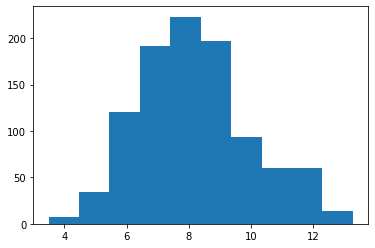

In [1]:
import numpy as np
from scipy.special import gamma, factorial
from matplotlib import pyplot as plt 

# Prior alpha = 7, beta = 1
# Start with a value of lambda given by 8.0 and compute the prior probability density of observing this value

def prior_prob_density(lam, alpha, beta):
     return(beta**(alpha) * lam**(alpha - 1) * np.exp(-beta*lam) / gamma(alpha))

def likelihood_density(data, lam):
    return(lam**(data) * np.exp(-lam)/ factorial(data))

# Starting value of lambda
lambda_current = 8.0
# Prior parameters alpha and beta
alpha = 7.0
beta = 1.0
# Observed data of 9 outages 
data_val = 9

lambda_array = np.zeros(1000)

for i in range(1000):
    
    # Current value 
    prior = prior_prob_density(lam=lambda_current, alpha=alpha, beta=beta)
    likelihood = likelihood_density(data=data_val, lam=lambda_current)
    posterior_current = likelihood * prior 
    
    # Proposed value
    lambda_proposed = np.random.normal(lambda_current, scale=0.5) # scale is our tuning parameter
    prior = prior_prob_density(lam=lambda_proposed, alpha=alpha, beta=beta)
    likelihood = likelihood_density(data=data_val, lam=lambda_proposed)
    posterior_proposed = likelihood * prior
    
    # Compute the probability of move
    ratio = posterior_proposed / posterior_current
    p_move = min(ratio, 1)
    random_draw = np.random.uniform(0,1)
    if (random_draw < p_move):
        lambda_current = lambda_proposed
        
    # Store the current value
    lambda_array[i] = lambda_current

plt.hist(lambda_array)

### The Metropolis-Hastings Algorithm

#### Overview

One of the limitations of the Metropolis algorithm was the requirement of a symmetric proposal distribution. The Metropolis-Hastings algorithm relaxes this requirement by providing a correction term if a non-symmetric proposal distribution is used. This correction is applied to $p_{move}$ and is of the form

$p_{move} = min( \dfrac{P(\mu_{proposed} | data) \cdot g(\mu_{current} | \mu_{proposed})}{P(\mu_{current} | data) \cdot g(\mu_{proposed} | \mu_{current})}, 1)$

where the correction term is 

$\dfrac{g(\mu_{current} | \mu_{proposed})}{g(\mu_{proposed} | \mu_{current})}$

The term $g(\mu_{current} | \mu_{proposed})$ is the probability density of drawing $\mu_{current}$ from a normal distribution centered around $\mu_{proposed}$. The standard deviation for this normal distribution is the tuning parameter. For a symmetric proposal distribution such as a normal distribution the correction term would be 1 since the probability density of drawing $\mu_{current}$ from a Gaussian centered at $\mu_{proposal}$ only depends on the distance between $\mu_{current}$ and $\mu_{proposal}$ (standard deviation is a hyperparameter that is fixed). Similarly, the probability density of drawing $\mu_{proposal}$ from a Gaussian centered around $\mu_{current}$ depends only on the distance between these two values, which is the same as before. Hence the numerator and the denominator are the same which results in the correction factor being 1.

#### Why do we need a correction term?

The correction term exists to account for the lack of symmetry in a non-symmetric proposal distribution. The Metropolis algorithm is therefore a specific case of the Metropolis-Hastings algorithm. When distributions other than a Gaussian is used as a proposed distribution, one can center $\mu_{current}$ and  $\mu_{proposal}$ on the mean, median or mode of the distribution. It is also possible to draw samples from a fixed distribution, this technique is called the Independent Metropolis-Hastings sampling algorithm.

#### What is the advantage of using a non-symmetric proposal distribution?

If the parameter we are seeking is bounded in value, using a symmetric distribution can result in invalid draws. Also, since we are working in a Bayesian setting we want to take advantage of our prior knowledge of this parameter. If it is known that the parameter has a certain distribution, we should be able to incorporate this information into our sampling process.

### Gibbs Sampling

In a Gibbs sampler, the proposal distribution matches the posterior conditional distribution and as a result the  proposals are always accepted (since there is no reason to reject unlike in the Metropolis algorithm where an arbitrary proposal distribution is used). This can be seen as a specific case of a Metropolis algorithm. One of the features of the Gibbs sampler is that it allows us to perform inference on more than one parameter at a time. This is done by drawing one parameter at a time conditional on the values of the other parameters. It iteratively works through the parameters using this process and continues till sufficient samples have been drawn for all parameters.

Additionally, Gibbs Sampling can draw proposals from an asymmetric distribution. In the example below, we will be drawing from a Gamma distribution which is not symmetric. Not having a pre-determined proposal distribution is seen sometimes as an advantage. The disadvantage of this method, however, is that you are required to decompose the joint distribution into the conditional distributions in order to sample from them.  If the conjugate solutions are known, the Gibbs sampler can be faster than the Metropolis-Hastings algorithm.

In the following example, we are going to to try the infer the parameters of a Normal distribution, i.e. the mean given by \\(\mu\\) and the precision given by \\(\tau\\). We use a Normal distribution here since we can use that to illustrate how Gibbs sampling can be used to estimate multiple parameters, i.e. \\(\mu\\) and \\(\tau\\), at the same time. 


#### The Problem Setup

We are going to use Gibbs sampling to estimate the parameters of a model that is used to represent some phenomenon. For the sake of this exercise, let us say that this is a Normal distribution and we have one data point as our observation.

Since we are using a Normal distribution, parameterized as $N(\mu, \tau)$ we will need the conjugate solution for computing our posterior from the priors. Here $\mu$ is the mean and $\tau$ is the precision of the Normal distribution. A word on notation as we proceed, using $\tau$ as an example - the draws are denoted by numbered subscripts such as $\tau_0$, $\tau_1$ while the hyperparameters for the prior and posterior distributions are denoted as $\tau_{prior}$ and $\tau_{posterior}$ respectively. 

$$\mu \sim N(\mu_{prior}, \tau_{prior})$$

Select $\mu_{prior}$ to be 12 and $\tau_{prior}$ to be 0.0625 which corresponds to a $\sigma$ of 4.

$$\tau \sim Gamma(\alpha_{prior}, \beta_{prior})$$ 

Select the shape parameter $\alpha_{prior}$ to be 25 and the rate parameter $\beta_{prior}$ to be 0.5. 

##### Conjugate Solution for Parameter \\(\mu\\) with a Normal Prior

$$\mu_{posterior} = (\tau_{prior} \mu_{prior} + \tau_0 \sum_i x_i) / (\tau_{prior} + n \tau_0)$$

$$\tau_{posterior} = \tau_{prior} + n * \tau_0$$

##### Conjugate Solution for  Parameter \\(\tau\\) with a Gamma Prior

$$\alpha_{posterior} = \alpha_{prior} + n/2$$

$$\beta_{posterior} = \beta_{prior} + \sum_i (x_i - \mu_{1})^2 / 2$$


#### Outline of the Algorithm

1. Specify reasonable priors for the parameters $\mu$ and $\tau$.
2. Choose one parameter from the two parameters above to start with, and assign an initial value. Let us assume that we start with $\tau$ here and select a value of $\tau_0$ from the Gamma prior distribution.
3. Start our first trial. We want to obtain a sample for $\mu$ from the posterior distribution of $\mu$ given the value of $\tau_0$. This is where we use our knowledge of the distribution and use a conjugate solution to obtain the posterior distribution of $\mu$. Now we draw a sample $\mu_1$ from this posterior distribution.
4. We continue with trial 1 since we need to obtain a value for $\tau_1$ conditional on the value of $\mu_1$. Similar to step (3), we use the conjugate solution to obtain a posterior distribution of $\tau$ given a value of $\mu_1$. Draw a value of $\tau_1$ from this distribution.
5. We accept both values we have drawn in steps (3) and (4) and trial 1 is now complete. Note that unlike the Metropolis algorithm, we do not stochastically accept or reject the proposals, we accept all drawn values.
6. Repeat steps (3) to (5) till we have a sufficient number of samples. This process of iteratively updating the parameters is loosely akin to coordinate ascent for optimization.


#### The details

 
**Please don't confuse $\tau$, which is the parameter our Normal distribution, with $\tau_0$ which is the hyperparameter of our mean $\mu$.** 

We have one data point that we are going to use to illustrate how Gibbs sampling works.  Obviously, in a real example we will have multiple data points in which case we will have to compute the likelihood and posterior given all those data values. We will walk through the first two trials of Gibbs Sampling.                                            
##### The Algorithm

<hr style = "border:1px dotted salmon"></hr>

a. With the priors set up, draw a value for $\tau_0$ from the Gamma prior distribution. Let us assume that this is 40.123.

<hr style = "border:1px dotted salmon"></hr>

b. Start trial 1. Calculate the posterior distribution of $\mu$ (Normal distribution) using the conjugate solution shown below. Here 'n' is the number of samples which happens to be 1 for our example.

$$\mu_{posterior} =(\tau_{prior} \mu_{prior} + \tau_0 \sum_i x_i) / (\tau_{prior} + n \tau_0)$$ 
$$= (0.0625 * 12 + 40.123 * 10.2) / (0.0625 + 1 * 40.123) = 10.2028$$
$$\tau_{posterior} = \tau_{prior} + n * \tau_0  = 0.0625 + 1 * 40.123 = 40.1855$$

c. Draw a value for $\mu_1$ from this computed posterior distribution for $\mu$ from step (b). Let us assume that this value of $\mu_1$ is <mark>10.5678</mark>.

d. With the given value of $\mu_1$, we now compute the posterior distribution of $\tau$ using a conjugate solution for the Gamma distribution. 

$$\alpha_{posterior} = \alpha_{prior} + n/2 = 25 + 1/2 = 25.5$$

$$\beta_{posterior} = \beta_{prior} + \sum_i (x_i - \mu_{1})^2 / 2 = 0.5 + (10.2 - 10.5678)^2 / 2 = 0.5676$$

e. Draw a value for $\tau_1$ from this posterior distribution computed in step (d). Let us assume that this value is <mark>45.678</mark>. Trial 1 is now complete.

<hr style = "border:1px dotted salmon"></hr>

f. Trial 2 will be similar to trial 1 except that we substitute the values for $\tau_0$ and $\mu_0$ with the updates $\tau_1$ and $\mu_1$ we obtained at the end of steps (c) and (e).

g. Update the posterior for $\mu$

$$\mu_{posterior} =(\tau_{prior} \mu_{prior} + \tau_1 \sum_i x_i) / (\tau_{prior} + n \tau_1) = (0.0625 * 12 + 45.678 * 10.2) / (0.0625 + 1 * 45.678) = 10.2025$$

$$\tau_{posterior} = \tau_{prior} + n * \tau_1  = 0.0625 + 1 * 45.678 = 45.7405$$

h. Draw a sample from this updated posterior as $\mu_2$. Let us assume that this is <mark>10.0266</mark>

i. Update the posterior for $\tau$. Note that the value of \\(\alpha_{posterior}\\) does not change.

$$\alpha_{posterior} = \alpha_{prior} + n/2 = 25 + 1/2 = 25.5$$ 

$$\beta_{posterior} = \beta_{prior} + \sum_i (x_i - \mu_{2})^2 / 2 = 0.5 + (10.2 - 10.0266)^2 / 2 = 0.5150$$

j. Draw a sample from this posterior distribution as $\tau_2$. Trial 2 is now complete.

k. By now you must have a sense of this process. If not,we simply repeat steps (f)
 to (j) till we have a sufficient number of samples.

<hr style = "border:1px dotted salmon"></hr>

#### Building the Inferred Distribution

Use the current values that we obtain at each step for both $\mu$ and $\tau$, and build a frequency distribution (histogram) from it. We can also create a joint distribution as well using a two-dimensional histogram.

### Hamiltonian Monte Carlo (also called Hybrid Monte Carlo)

The best resource on the topic! - 

[Betancourt Youtube Video](https://www.youtube.com/watch?v=VnNdhsm0rJQ)

[![Betancourt Youtube Video](https://statmodeling.stat.columbia.edu/wp-content/uploads/2016/06/Screen-Shot-2016-06-10-at-5.29.51-PM.png)](https://www.youtube.com/watch?v=VnNdhsm0rJQ "Betancourt")

[Stan page on HMC](https://mc-stan.org/docs/2_21/reference-manual/hamiltonian-monte-carlo.html)

[Wikipedia Reference](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo)


We won't go into a lot of detail of HMC here since this is quite conceptually involved. 
This is based on the solution of differential equations known as Hamilton's equations for the motion of a particle in space. This relates the position of the particle \\(x\\), the momentum \\(m\\) and the Hamiltonian $H$ through the following equations 

$$\dfrac{dx}{dt} = \dfrac{dH}{dm}$$

$$\dfrac{dm}{dt} = - \dfrac{dH}{dx}$$


These differential equations depend on the probability distributions we are trying to learn. We navigate these distributions by moving around them in a trajectory using steps that are defined by the position and momentum at that position. Like in many algorithms, the momentum term allows the particle to move up a posterior space, as opposed to always moving down. The steps that we take also depend on the curvature of the posterior. Navigating these trajectories can be a very expensive process and the goal is to minimize this computational process.

HMC is based on the notion of conservation of energy. The Hamiltonian is intuitively the sum of the kinetic and potential energy of the particle, or in simple terms it measures the total energy of the system. 

$$H(x,m) = U(x) + KE(m)$$

where \\(U(x)\\) is the potential energy of the system and \\(KE(m)\\) is the kinetic energy of the system. The potential energy is measured using the negative log density of the posterior distribution.  When the sampler trajectory is far away from the probability mass center, it has high potential energy but low kinetic energy. When the trajectory is closer to the center of the probability mass it will have high kinetic energy but low potential energy. The kinetic energy term (momentum) involves a mass matrix \\(\Sigma\\) that is also the covariance of the normal distribution from which we randomly draw a momentum value \\(m\\) in our Monte Carlo process. An outline of the steps involved in this algorithm is given below.

##### Outline 

* We start from an initial position \\(x_0\\). 

* At each step, we select a random value for momentum from a proposal distribution. This is usually a normal distribution such that

$$m \sim N(\mu, \Sigma)$$

* From the current position and using the sampled value for momentum, we run the particle for time $L \cdot \Delta t$ using a leapfrog integrator which is a numerical integration scheme to march forward in time. The terms $\Delta t$ refers to the time step taken for the integrator, and $L$ refers to the total number of steps taken. $L$ is a hyperparameter that needs to be tuned carefully. If we are at a spatial location indicated by step \\(n\\), we start from time 0 (integration time) and integrate till time \\(t\\) to get the following

$$x_n(0) \longrightarrow x_n(L \Delta t)$$

$$m_n(0) \longrightarrow m_n(L \Delta t)$$

* The leapfrog integration introduces errors due to the fact that it is a numerical integration method and not an exact integral. This is corrected using a Metropolis-Hastings step that probabilistically accepts the new values of $x_{n+1}$ as $x_n(L \cdot \Delta t)$ or the original location $x_n(0)$. The acceptance probability used here is given below. Here \\(p(x_n(L \cdot \Delta t))\\) corresponds to the posterior probability density at the end of the integration scheme and \\(p(x_n(0))\\) coresponds to the posterior probability density at the beginning of the integration scheme. Also, \\(q(m)\\) is the probability density of the proposal distribution for the momentum. 

$$ acceptance \; rate = \dfrac{p(x_n(L \cdot \Delta t))}{p(x_n(0))} \times \dfrac{q(m(L \cdot \Delta t))}{q(m(0))}$$

* Draw a random value \\(u\\) from a uniform distribution \\(U[0,1]\\). If \\(r > u\\), move to the location \\(x_n(L \cdot \Delta t)\\) otherwise remain at location \\(x_n(0)\\).

* Record the new position \\(x_{n+1}\\). This is repeated for 'n' or a number of spatial steps. 


##### Impact of \\(T\\) in HMC

Now \\(T\\) can be defined such that

$$T = L \cdot \Delta t$$

When there are divergences the sampling process that happens in regions of high curvature, we might have to resort to smaller values of \\(\Delta t\\).

The use of larger than desirable values for \\(T = L \cdot \Delta t\\) results in the sampler making U-turns at locations of high curvature in the posterior space. This can be wasteful since the sampler then ends up wasting time retracing its steps. One way to mitigate this is through a preliminary run of tuning samples to heuristically select values of  \\(T\\) that work better.

A No U-Turn sampler (NUTS) is an extension of the HMC where the number of steps of the integrator $L$ and therefore \\(T\\) is automatically tuned. For regions of high curvature a smaller value of \\(T\\) is used so as to minimize U-turns whereas for flatter regions, a larger \\(T\\) is used to move faster. Therefore an adaptive \\(T\\) is used that is locally optimal as opposed to a single value of \\(T\\). Even though we don't know what the posterior looks like (since this is what we are inferring and therefore we can't evaluate its curvature), the NUTS algorithm has ways to estimate it.

NUTS uses a scaling matrix that defines the shape of the sampling distribution through the covariance matrix so that the jumps are bounded in all directions. Poor choice of this scaling matrix can result in the sampling stopping or stalling. Fortunately, tools such as PyMC3 can automatically determine appropriate parameter values during the tuning phase.


## Properties of MCMC

前面介绍了如何用各种算法来构建后验分布。现在看看怎么评价这些算法返回的解的质量。接下来会看到一些MCMC的属性，来帮助我们做评价。

### Representativeness

来自 MCMC 过程的样本应该代表后验分布，它应该彻底覆盖分布空间。推断分布的最终状态应该独立于初始值。

有两种方法可以衡量您的推断分布是否代表真实分布：

1. 对收敛轨迹的目视检查

2. 对收敛的数值度量

轨迹就是 y 轴上表示的样本值与 x 轴上表示的采样时的迭代次数的关系图。前“n”个样本被丢弃，因为采样过程正在空间中移动，试图找到具有代表性后验密度的区域。这“n”个样本称为老化，它们通常会被丢弃。 'n' 的选择取决于分布，但通常选择 500 左右作为足够数量的样本。

如下图所示，例子是最后实践的例子，图上部分的子图是所有关心的变量的后验分布；下面左边的图是每个变量各个不同的trace出来的分布图，每个小子图上都有多条trace的分布，可以看到每次分布都差不多，这是好的。下面右侧的图就是trace plot。

数值度量包括 Gelman-Rubin 统计量（也称为潜在比例缩减因子或收缩因子）。这测量了链之间的样本方差与链内的方差的比率。大于 1 的数字通常表示缺乏收敛。

![Trace plot](pictures/image-20201207170920197.png)

<center> Trace plot </center>

### Accurate

样本应该足够大，以使估计值稳定。因此，分别运行多样本“链”以确保结果的一致性。如果链变化很大，如通过检查样品的直方图或密度图所见，则认为样品不稳定，这需要进一步调查。自相关是一个常见问题，其中抽取的样本彼此不完全独立。计算出的有效样本量可为您提供可用于构建分布的真实样本数。

另一种衡量准确性的方法是蒙特卡罗标准误差 (MCSE)。如果我们绘制 4 个链，则每次的样本均值和真实均值可能会有所不同。 MCSE 只是这个计算平均值的标准误差。样本量越大，MCSE 越小。

### Efficiency

应该有效率地生成覆盖分布的样本，以便适当地解析更清晰的区域。最低和最高效的 MCMC 算法之间的运行时间存在很大差异。对于参数维数增加的更复杂模型，普通的 Metropolis 算法可能完全不切实际。

尽可能并行运行多条链，因为每条链都很麻烦计算的。了解手头的问题有助于选择正确的采样算法，从而提高采样效率。

#### Mean-center the data

在执行 MCMC 采样之前对数据进行均值中心化是有利的。下面的线性回归示例有助于说明这一点。下图是一个一维线性回归问题，由下式给出

$$ y = \alpha x + \beta $$

回归线的类别以及相关的不确定性由这些线的分布反映出来。这里 \\(\alpha\\) 是线的斜率，\\(\beta\\) 是 y 轴截距。这些线绕过数据的 x 和 y 值的平均值，并围绕这个“枢轴点”旋转。对于每条线，随着斜率增加，y 轴截距减小，反之亦然。因此，这些系数之间存在很强的相关性。

![Regression lines](pictures/family_regression.png)

<center> Family of Regression lines </center>

下图说明了线性回归系数 \\(\alpha\\) 和 \\(\beta\\) 之间的这种相关性。图里表示的分布空间具有非常窄的对角线形状，这对于采样来说并不理想。如果您考虑 Gibbs 采样的示例，您选择一个参数 \\(\alpha\\) 然后通过沿着平行于位于\\(\alpha\\)  值处的 y 轴的线移动来搜索另一个参数 \\(\beta\\)。由于相关性图所指示的参数空间的这种狭窄形状，这具有有限的范围。因此，收敛可能需要很长时间。

当您对数据进行均值中心化时，您从所有值中减去 x 的平均值，这导致 x 值以零为中心。轴心点（不完全在平均值但接近平均值）现在在 x 轴上几乎超过零，这意味着 y 轴截距变化不大。这打破了两个坐标之间的相关性，使其更容易采样。

![Inverse correlation](pictures/inverse_correlation.png)

<center> Inverse correlation of the intercepts </center>